In [48]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from collections import Counter
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.ndimage import shift
from scipy.signal import fftconvolve
from numpy.linalg import norm
from tqdm import tqdm
from scipy.optimize import curve_fit
import pickle
import sys
sys.path.append('../lib')
from detection_methods import compare_trajectory_method, plt_accuracy_results, trajectory_till, trajectory_till_stepwise, trajectory_gauss, plt_accuracy_results, make_test_trajectory, trajectory_polar_comparison,save_result, bin_indices
from fast_detection_methods import trajectory_mean, trajectory_corr, trajectory_gauss
from movie_processing import movie_to_array,clean_problem_pixels
import os
    

In [49]:
filename=r'\\134.76.13.158\betzlab\Julian\microcope_scripts\detection\data\Hz10_oscillation\_100nm.npy'
movie = np.load(filename)
movie=movie.astype(np.int32)
image_1=movie[0]

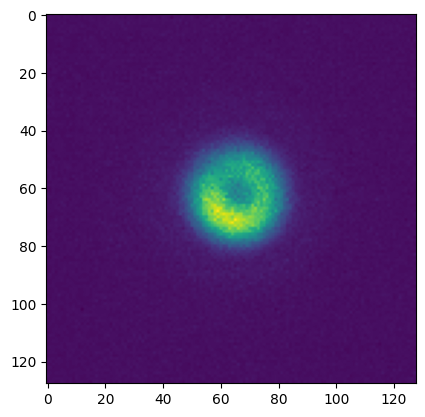

In [50]:
plt.imshow(image_1)

In [51]:
def select_file(khz_value, files):
    for file in files:
        if f"{khz_value}_khz" in file:
            return file
    return None

data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2'

file_list =[ file for file in  os.listdir(data_path) if file.endswith('.avi')]

freq_list = [1,5,10,25]

image_list = []
for f in freq_list:
    file = select_file(f, file_list)
    if file is None:
        continue
    file_path = os.path.join(data_path, file)
    numpy_movie = movie_to_array(file_path, max_frames=10)
    numpy_movie = clean_problem_pixels(numpy_movie)
    image_list.append(numpy_movie[0])


Processing video: 100%|██████████| 10/10 [00:00<00:00, 10022.23frame/s]


In [5]:
for image in image_list:
    print(image.shape)

(74, 128)
(62, 128)
(74, 128)
(62, 128)


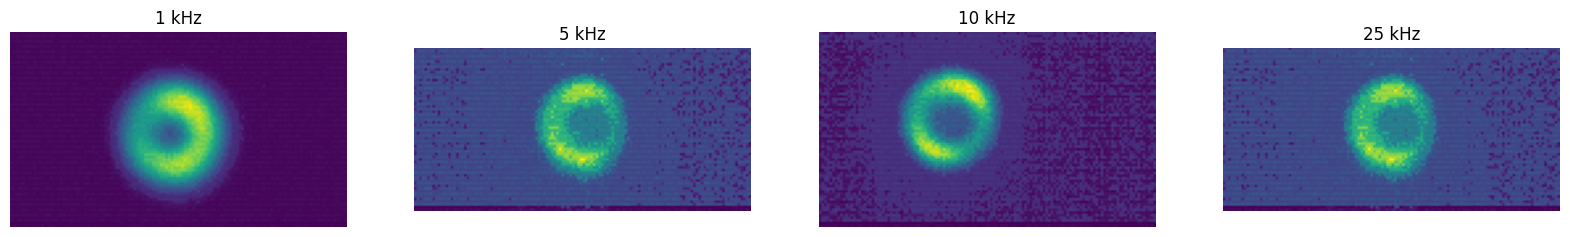

In [6]:
#plot all images beside each other
fig, ax = plt.subplots(1,len(image_list), figsize=(20,10))
for i, image in enumerate(image_list):
    ax[i].imshow(image)
    ax[i].set_title(f"{freq_list[i]} kHz")
    ax[i].axis('off')

In [45]:
trajectorie_1, movie_1 = make_test_trajectory(image_1,0.01,1,0,1000)

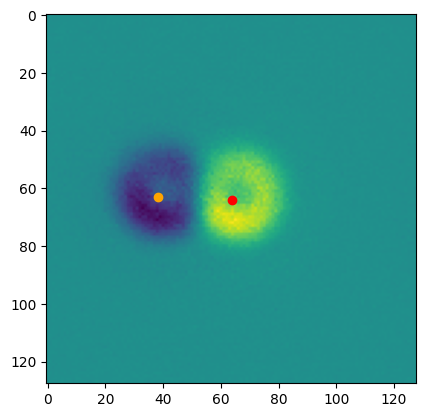

In [46]:
center_of_frame = (image_1.shape[0]//2, image_1.shape[1]//2)
plt.scatter(center_of_frame[1], center_of_frame[0], c='r')
shifted_frame = center_of_frame + trajectorie_1[-1]
plt.scatter(shifted_frame[1], shifted_frame[0], c='orange')
plt.imshow(movie_1[0]- movie_1[-1])

In [47]:
tra_mean_1 = trajectory_mean(movie_1)
tra_corr_1=trajectory_corr(movie_1)
tra_gauss_1 = trajectory_gauss(movie_1)
#tra_till_1 = trajectory_till(movie_1)
#tra_till_stepwise_1 = trajectory_till_stepwise(movie_1)

Processing frames: 100%|██████████| 1001/1001 [00:00<00:00, 13970.08frame/s]
c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Filling in frames: 100%|██████████| 1000/1000 [00:00<00:00, 345409.21it/s]


In [17]:
def compare_trajectories(tray_test,tray_ground_truth):
    step_sizes=[]
    procentual_accuracy=[]
    squared_error=[]
    for i in range(len(tray_ground_truth)-1):
        step_truth=tray_ground_truth[i+1]-tray_ground_truth[i]
        step_calc=tray_test[i+1]-tray_test[i]
        step_sizes.append(norm(step_truth))
        procentual_accuracy.append(norm(step_truth-step_calc)/norm(step_truth))
        squared_error.append(norm(step_truth-step_calc)**2)
    
    Stepsize_bins=[]
    stepsize_bin_accuracies=[]
    sigma_stepsize_bin_accuracies=[]
    mean_squared_error=[]
    mean_squared_error_uncertainty=[]
    num_bins = 10
    #return step_sizes
    binned_indices = bin_indices(np.log(step_sizes), num_bins)
    step_sizes=np.array(step_sizes)
    procentual_accuracy=np.array(procentual_accuracy)
    squared_error=np.array(squared_error)
    for bin_idx, indices in binned_indices.items():
        if len(indices)<2:
            continue
        #return indices
        Stepsize_bins.append(np.mean(step_sizes[indices]))
        stepsize_bin_accuracies.append(np.mean(procentual_accuracy[indices]))
        sigma_stepsize_bin_accuracies.append(np.std(procentual_accuracy[indices]))
        mean_squared_error.append(np.mean(squared_error[indices]))
        mean_squared_error_uncertainty.append(np.std(squared_error[indices])/len(indices)**0.5)
    return Stepsize_bins, mean_squared_error, mean_squared_error_uncertainty
def plot_comparison(tray_test,tray_ground_truth, **kwargs):
    stepsize_bins, mean_squared_error, mean_squared_error_uncertainty = compare_trajectories(tray_test,tray_ground_truth)
    sorted_indices = sorted(range(len(stepsize_bins)), key=lambda k: stepsize_bins[k])
    Stepsize_bins = [stepsize_bins[i] for i in sorted_indices]
    stepsize_bin_mse = [mean_squared_error[i] for i in sorted_indices]
    stepsize_bin_mse_uncertainty = [mean_squared_error_uncertainty[i] for i in sorted_indices]
    plt.errorbar(Stepsize_bins, stepsize_bin_mse, yerr=stepsize_bin_mse_uncertainty, fmt='o', **kwargs)
    


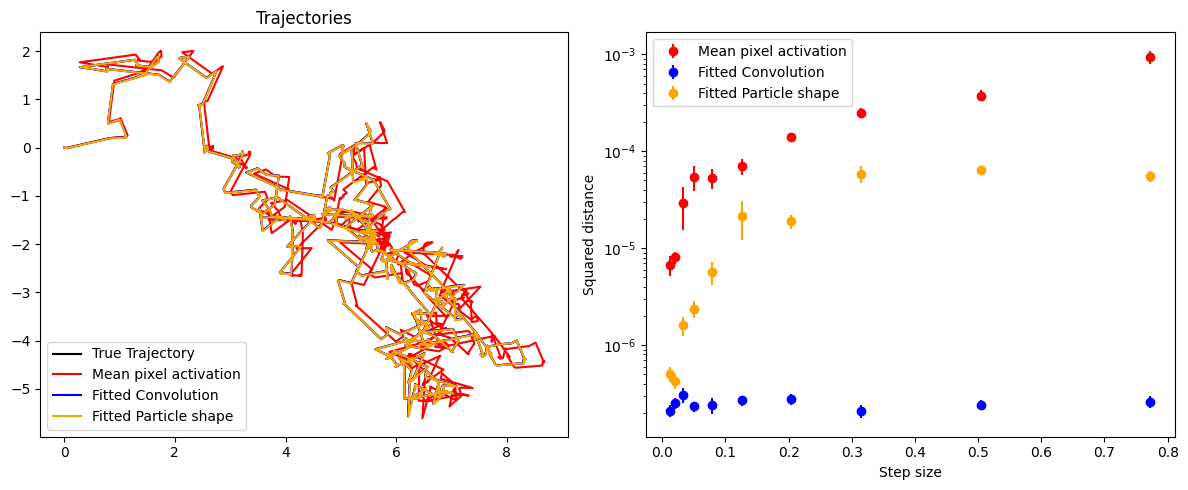

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the trajectories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(trajectorie_1[:,1], trajectorie_1[:,0], label='True Trajectory', color='black')
plt.plot(tra_mean_1[:,1], tra_mean_1[:,0], label='Mean pixel activation', color='red')
plt.plot(tra_corr_1[:,1], tra_corr_1[:,0], label='Fitted Convolution', color='blue')
plt.plot(tra_gauss_1[:,1], tra_gauss_1[:,0], label='Fitted Particle shape', color='orange')
#plt.plot(tra_till_1[:,1], tra_till_1[:,0], label='Till')
#plt.plot(tra_till_stepwise_1[:,1], tra_till_stepwise_1[:,0], label='Till Stepwise')
plt.legend()


plt.title('Trajectories')

# Compute the squared distance function
def squared_distance(traject1, traject2):
    return np.sum((traject1 - traject2)**2, axis=1)

# Plotting the square distance from each trajectory to the true trajectory
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plot_comparison(tra_mean_1, trajectorie_1, color='red', label='Mean pixel activation')
plot_comparison(tra_corr_1, trajectorie_1, color='blue', label='Fitted Convolution')
plot_comparison(tra_gauss_1, trajectorie_1, color='orange', label='Fitted Particle shape')
plt.yscale('log')
plt.xlabel('Step size')
plt.ylabel('Squared distance')
plt.legend()
plt.tight_layout()  # Adjust spacing between plots
plt.show()


In [ ]:
results_list=[]
trajectories = [tra_mean_1, tra_corr_1, tra_gauss_1]
names_list=["Mean pixel activation", "Fitted Convolution", "Fitted Particle shape"]
colors_list=["red", "blue", "orange"]
for calc_traj , name, color in zip(trajectories, names_list, colors_list):
    Stepsize_bins, stepsize_bin_accuracies, sigma_stepsize_bin_accuracies = compare_trajectories(calc_traj, trajectorie_1)
    results = {
        "Stepsize_bins": Stepsize_bins,
        "stepsize_bin_accuracies": stepsize_bin_accuracies,
        "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
        "test_traj": trajectorie_1,
        "calc_traj": calc_traj,
        "picture_noise": 0,

        "name": name
    }
    #plt_accuracy_results(results, name, color)
    trajectory_polar_comparison(results, name)
    results_list.append(results)

In [ ]:
noise_list = []
noise_image_list = []
for image in image_list:
    noise_image =image[:20,:20]
    noise = np.std(noise_image)
    noise_image_list.append(noise_image)
    noise_list.append(noise)
#plot all images beside each other
fig, ax = plt.subplots(1,len(noise_image_list), figsize=(20,10))
for i, image in enumerate(noise_image_list):
    ax[i].imshow(image)
    ax[i].set_title(f"frequency: {freq_list[i]} kHz\n noise: {noise_list[i]}")
    ax[i].axis('off')

In [ ]:
moive_list = []
trajectorie_list = []
for image , noise in zip(image_list, noise_list):
    trajectorie, movie = make_test_trajectory(image,0.01,0.1,noise,500)
    trajectorie_list.append(trajectorie)
    moive_list.append(movie)


In [ ]:
tra_mean_list = []
tra_corr_list = []
tra_gauss_list = []

for movie in moive_list:
    tra_mean_list.append(trajectory_mean(movie))
    tra_corr_list.append(trajectory_corr(movie))
    tra_gauss_list.append(trajectory_gauss(movie))

In [ ]:
def extreme_stepsize_filter(trajectory, max_stepsize=0.1):
    step_sizes = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
    exrreme_stepsize_indices = np.where(step_sizes > max_stepsize)[0]
    #now set all those steps to zero
    for i in exrreme_stepsize_indices:
        step = trajectory[i+1] - trajectory[i]
        trajectory[i+1:] -= step
    return trajectory

In [ ]:
plt.plot(trajectorie_1[:,1], trajectorie_1[:,0], label='True Trajectory', color='black')
plt.plot(tra_mean_1[:,1], tra_mean_1[:,0], label='Mean pixel activation', color='red')
plt.plot(tra_corr_1[:,1], tra_corr_1[:,0], label='Fitted Convolution', color='blue')
plt.plot(tra_gauss_1[:,1], tra_gauss_1[:,0], label='Fitted Particle shape', color='orange')

hallo


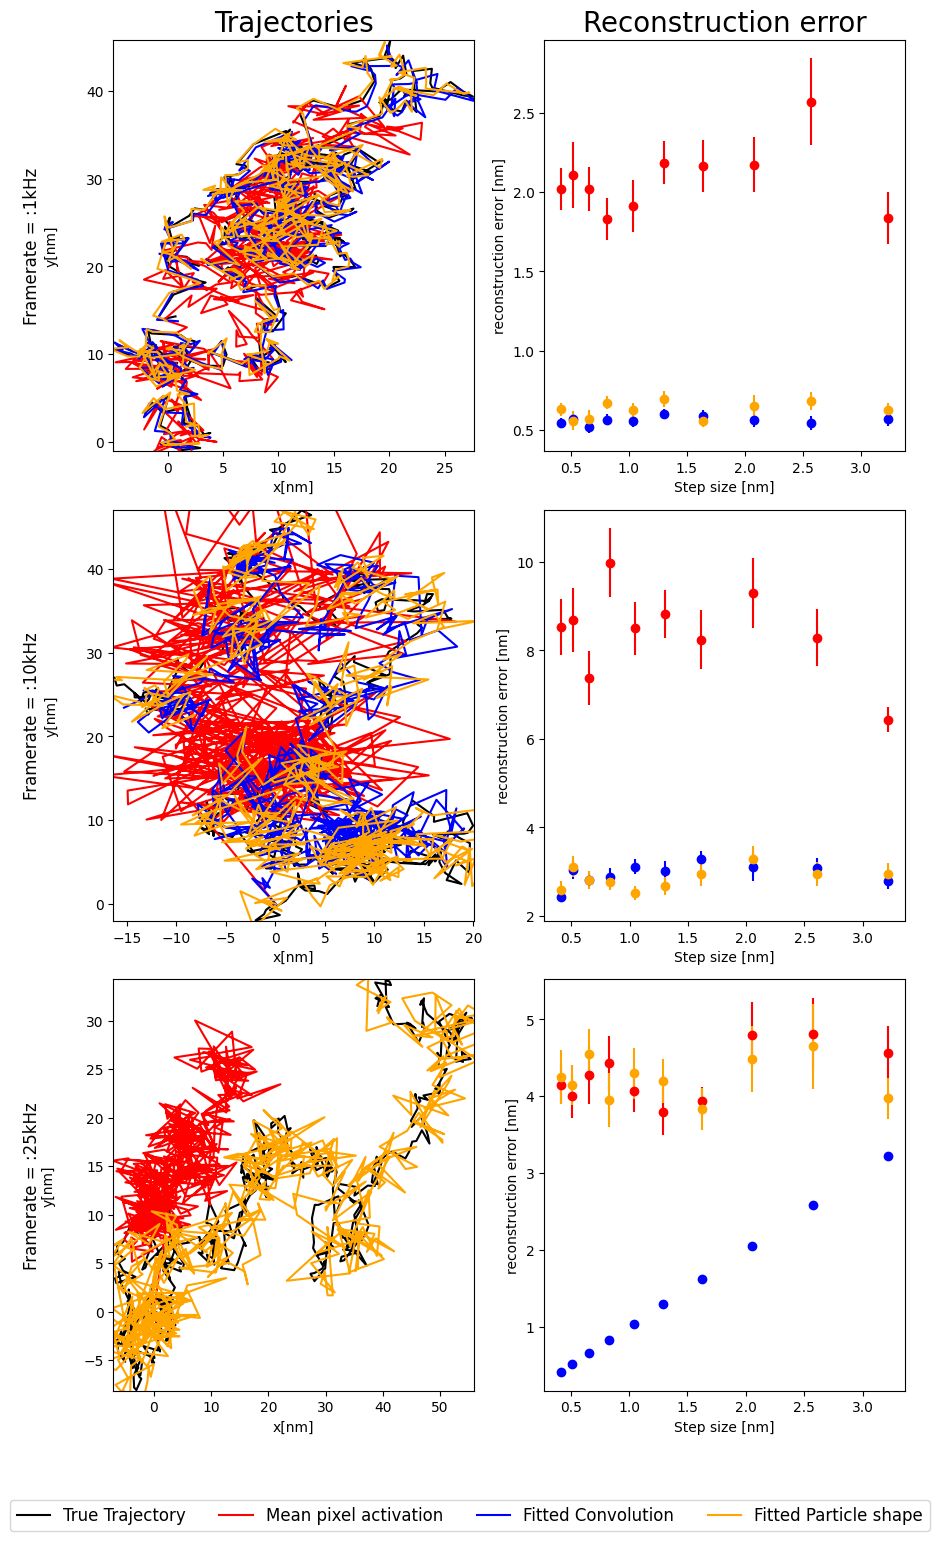

In [72]:
import matplotlib.pyplot as plt
import numpy as np

nm_pro_pixel = (0.036768956332537246 * 1000)

def plot_comparison(tray_test, tray_ground_truth, ax, **kwargs):
    stepsize_bins, mean_squared_error, mean_squared_error_uncertainty = compare_trajectories(tray_test, tray_ground_truth)
    sorted_indices = sorted(range(len(stepsize_bins)), key=lambda k: stepsize_bins[k])
    Stepsize_bins = [stepsize_bins[i] for i in sorted_indices]
    stepsize_bin_error = [np.sqrt(mean_squared_error[i]) for i in sorted_indices]
    stepsize_bin_error_uncertainty = [0.5 * mean_squared_error_uncertainty[i] / np.sqrt(mean_squared_error[i]) for i in sorted_indices]
    ax.errorbar(Stepsize_bins, stepsize_bin_error, yerr=stepsize_bin_error_uncertainty, fmt='o', **kwargs)

fig, axs = plt.subplots(3, 2, figsize=(9, 15))  # 3 rows, 2 columns
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between subplots

frequencies = ['1kHz', '10kHz', '25kHz']

for i, (trajectory_PX, tra_mean_PX, tra_corr_PX, tra_gauss_PX) in enumerate(zip(trajectorie_list, tra_mean_list, tra_corr_list, tra_gauss_list)):
    if i == 1:
        continue
    elif i > 1:
        i = i - 1

    ax_left = axs[i, 0]
    ax_right = axs[i, 1]

    if i == 0:
        ax_left.set_title('Trajectories', fontsize=20)
        ax_right.set_title('Reconstruction error', fontsize=20)


    # Plotting the trajectories
    tra_corr_PX = extreme_stepsize_filter(tra_corr_PX.copy(), max_stepsize=10.)
    trajectory = trajectory_PX * nm_pro_pixel
    tra_mean = tra_mean_PX * nm_pro_pixel
    tra_corr = tra_corr_PX * nm_pro_pixel
    tra_gauss = tra_gauss_PX * nm_pro_pixel

    ax_left.plot(trajectory[:, 1], trajectory[:, 0], label='True Trajectory', color='black')
    ax_left.plot(tra_mean[:, 1], tra_mean[:, 0], label='Mean pixel activation', color='red')
    ax_left.plot(tra_corr[:, 1], tra_corr[:, 0], label='Fitted Convolution', color='blue')
    ax_left.plot(tra_gauss[:, 1], tra_gauss[:, 0], label='Fitted Particle shape', color='orange')

    x_min = trajectory[:, 1].min() - 0.1
    x_max = trajectory[:, 1].max() + 0.1
    y_min = trajectory[:, 0].min() - 0.1
    y_max = trajectory[:, 0].max() + 0.1
    ax_left.set_xlim(x_min, x_max)
    ax_left.set_ylim(y_min, y_max)
    ax_left.set_xlabel('x[nm]')
    ax_left.set_ylabel('y[nm]', labelpad=20)  # Increase labelpad to avoid overlap

    # Plotting the square distance from each trajectory to the true trajectory
    plot_comparison(tra_mean, trajectory, ax_right, label='Mean pixel activation', color='red')
    plot_comparison(tra_corr, trajectory, ax_right, label='Fitted Convolution', color='blue')
    plot_comparison(tra_gauss, trajectory, ax_right, label='Fitted Particle shape', color='orange')
    
    ax_right.set_xlabel('Step size [nm]')
    ax_right.set_ylabel('reconstruction error [nm]')
    #ax_right.set_yscale('log')
    if i ==2:
        print("hallo")
        #ax_right.set_yticks([1.,2.,4.])
    # Add labels on the side for each row
    ax_left.annotate(f"Framerate = :{frequencies[i]}", xy=(-0.2, 0.5), xycoords='axes fraction', rotation=90, ha='right', va='center', fontsize=12)

# Add a single legend for all subplots
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:4], labels[:4], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.03), fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust the bottom spacing to make room for the legend

plt.show()

In [73]:
names_list=["mean","corr","gauss"]
colors_list=["blue","green","red"]
result_dict_list = []
for trajectory,tra_mean, tra_corr, tra_gauss in zip(trajectorie_list,tra_mean_list, tra_corr_list, tra_gauss_list):
    trajectories = [tra_mean, tra_corr, tra_gauss]
    results_dict = {}
    for tra, name, color in zip(trajectories, names_list, colors_list):
        Stepsize_bins, stepsize_bin_accuracies, sigma_stepsize_bin_accuracies = compare_trajectories(tra, trajectory)
        results = {
            "Stepsize_bins": Stepsize_bins,
            "stepsize_bin_accuracies": stepsize_bin_accuracies,
            "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
            "test_traj": trajectory,
            "calc_traj": tra,
            "picture_noise": 0,
            "color": color, # "blue", "green", "red

            "name": name
        }
        results_dict[name] = results
    result_dict_list.append(results_dict)


In [74]:
for result_dict, f in zip(result_dict_list, freq_list):
    for name, result in result_dict.items():
        Stepsize_bins = result["Stepsize_bins"]
        stepsize_bin_accuracies = result["stepsize_bin_accuracies"]

        # Sort Stepsize_bins and their corresponding accuracies
        sorted_indices = sorted(range(len(Stepsize_bins)), key=lambda k: Stepsize_bins[k])
        Stepsize_bins = [Stepsize_bins[i] for i in sorted_indices]
        stepsize_bin_accuracies = [stepsize_bin_accuracies[i] for i in sorted_indices]

        # Find the critical_stepsize
        critical_stepsize = None
        for i in range(1, len(stepsize_bin_accuracies)):
            if stepsize_bin_accuracies[i-1] > 1 and stepsize_bin_accuracies[i] <= 1:
                critical_stepsize = Stepsize_bins[i]
                break
        print(f"{name} - {f} kHz: {critical_stepsize}")
        # Assign the critical_stepsize to the result dictionary
        result["critical_stepsize"] = critical_stepsize


mean - 1 kHz: None
corr - 1 kHz: None
gauss - 1 kHz: None
mean - 5 kHz: None
corr - 5 kHz: None
gauss - 5 kHz: None
mean - 10 kHz: None
corr - 10 kHz: None
gauss - 10 kHz: None
mean - 25 kHz: None
corr - 25 kHz: None
gauss - 25 kHz: None


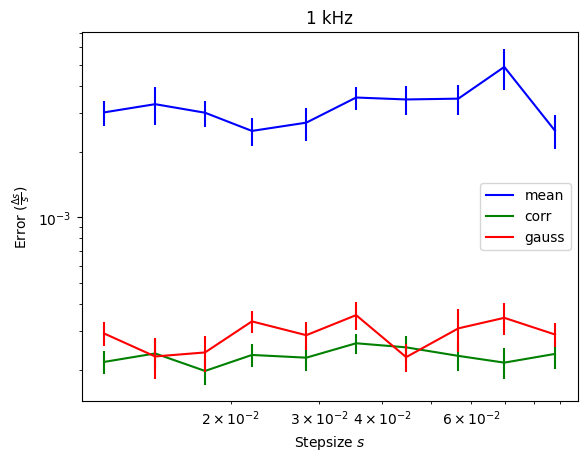

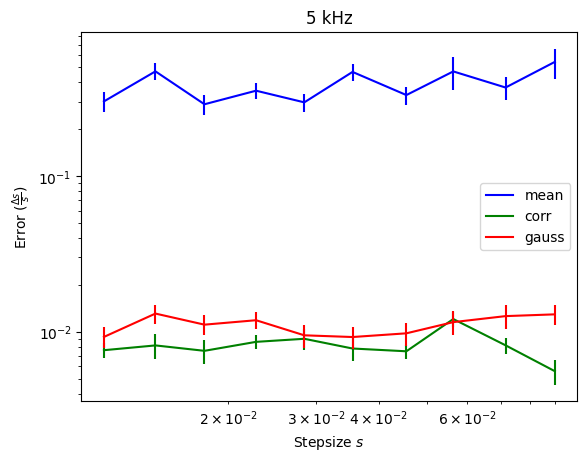

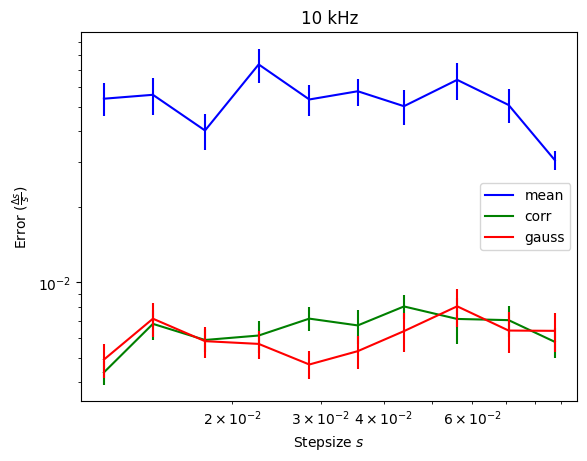

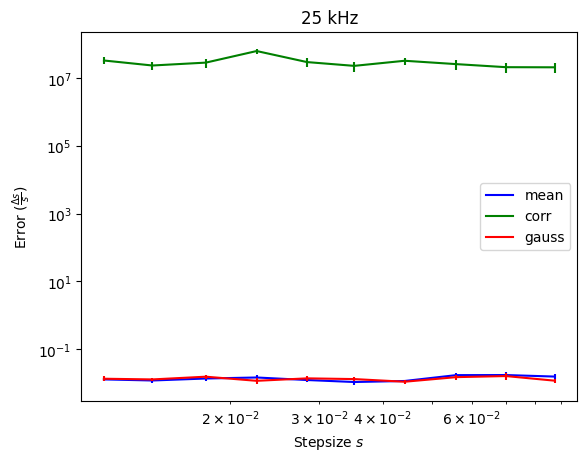

In [75]:
for result_dict, f in zip(result_dict_list, freq_list):
    for name in names_list:
        plt_accuracy_results(result_dict[name], name, result_dict[name]["color"])
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Stepsize $s$')
    plt.title(f'{f} kHz')
    plt.ylabel('Error ($\\frac{\\Delta s}{s}$)')
    plt.show()

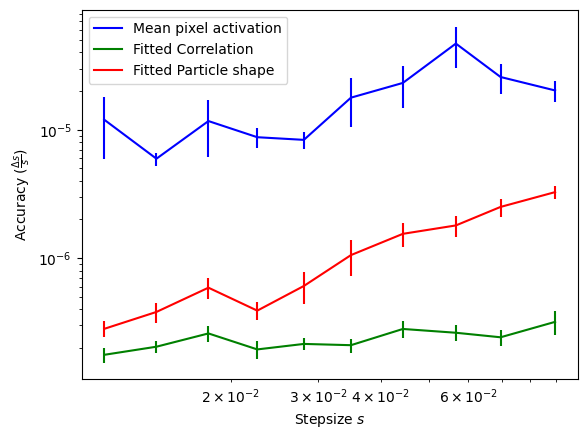

In [76]:
for result, color in zip(results_list, colors_list):
    name = result["name"]
    plt_accuracy_results(result, name, color)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Stepsize $s$')
plt.ylabel('Accuracy ($\\frac{\\Delta s}{s}$)')
plt.show()


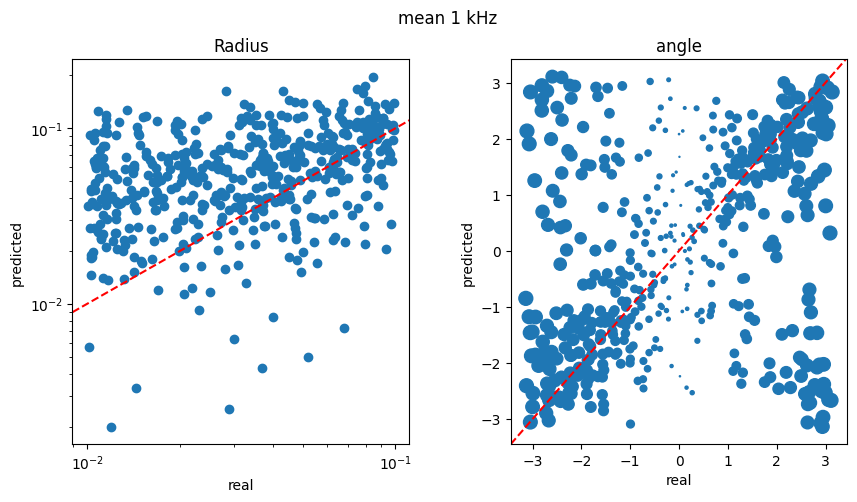

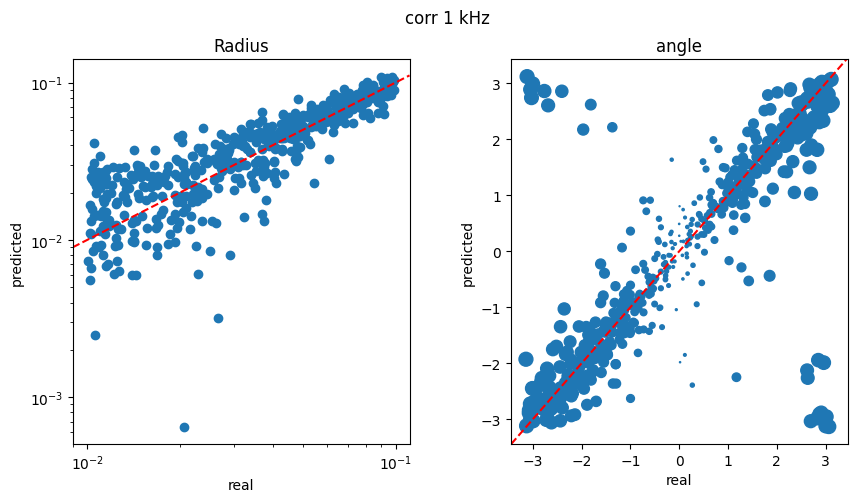

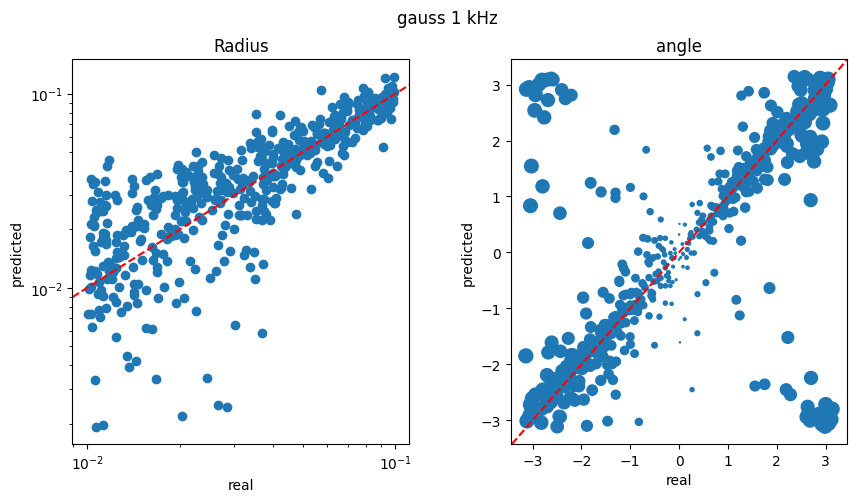

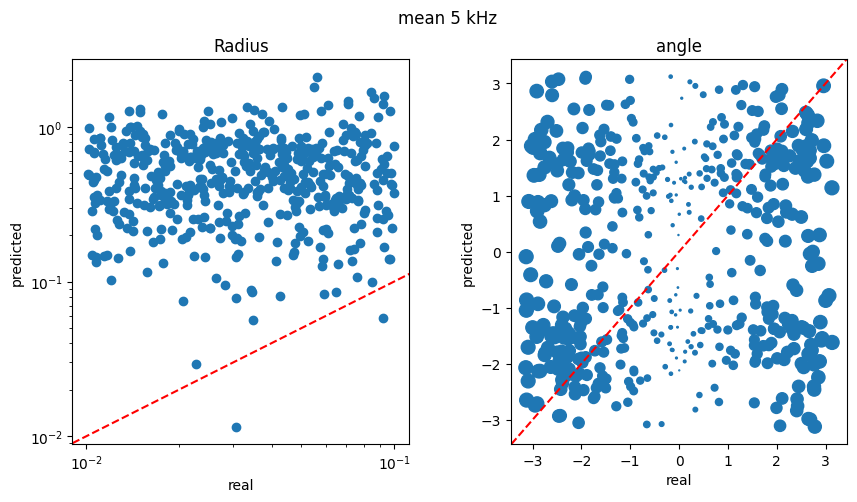

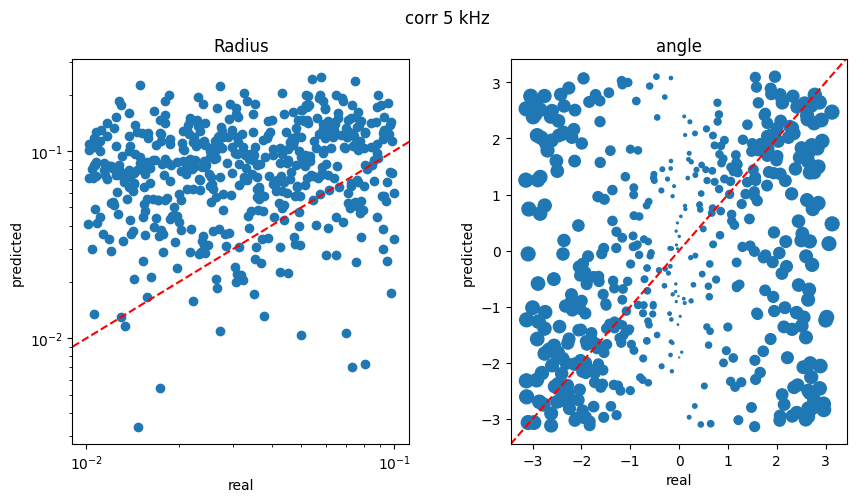

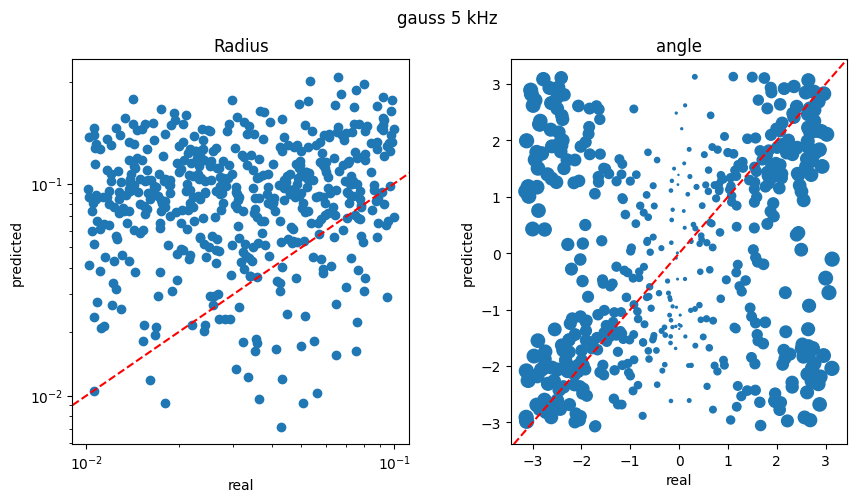

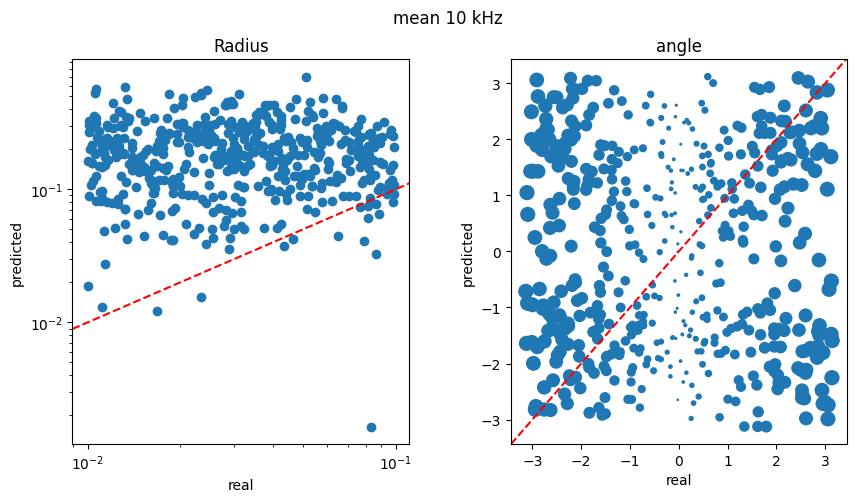

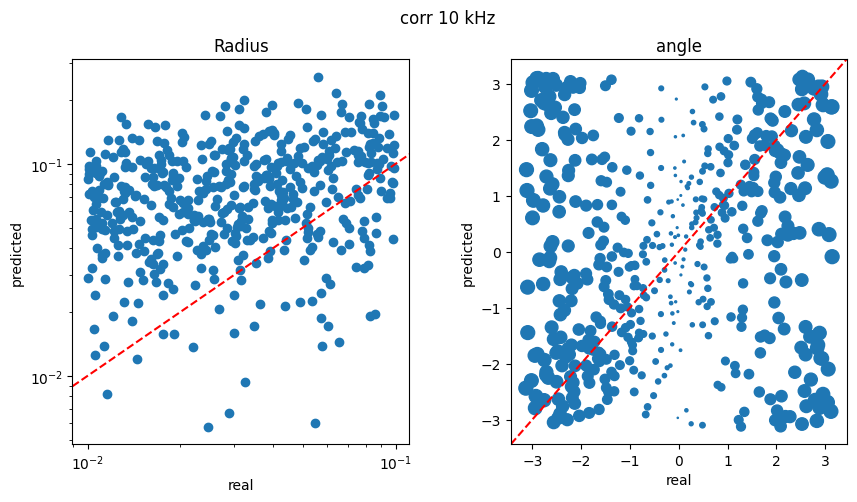

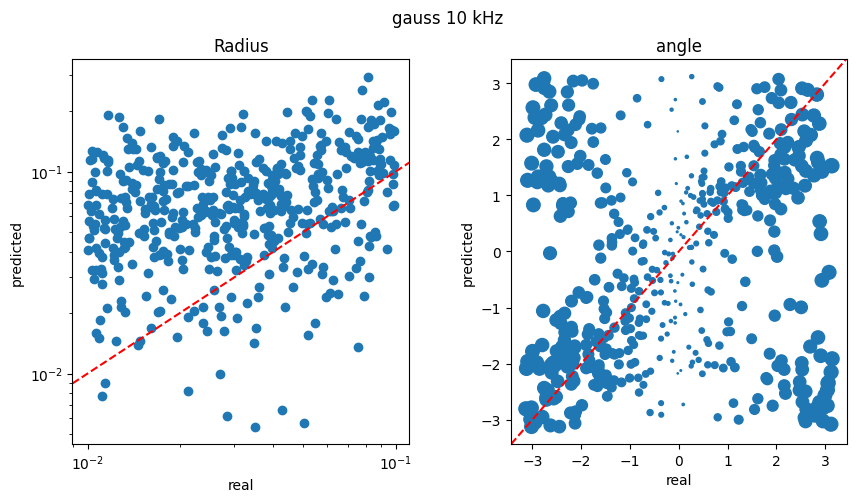

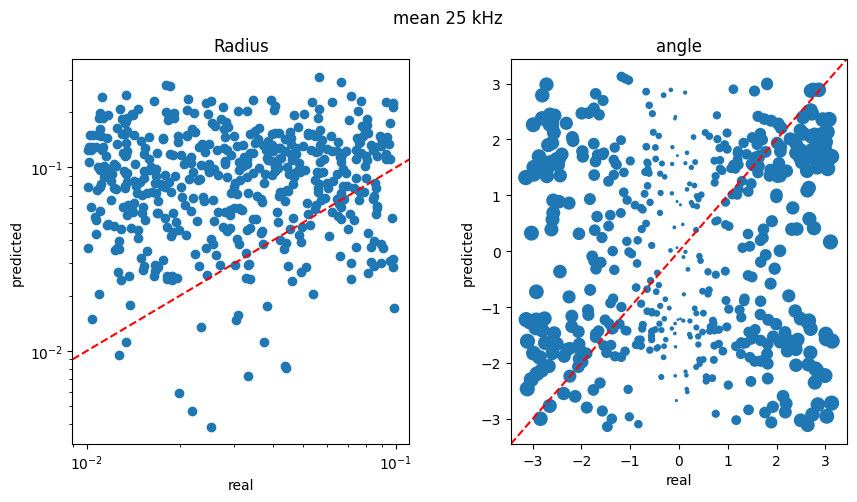

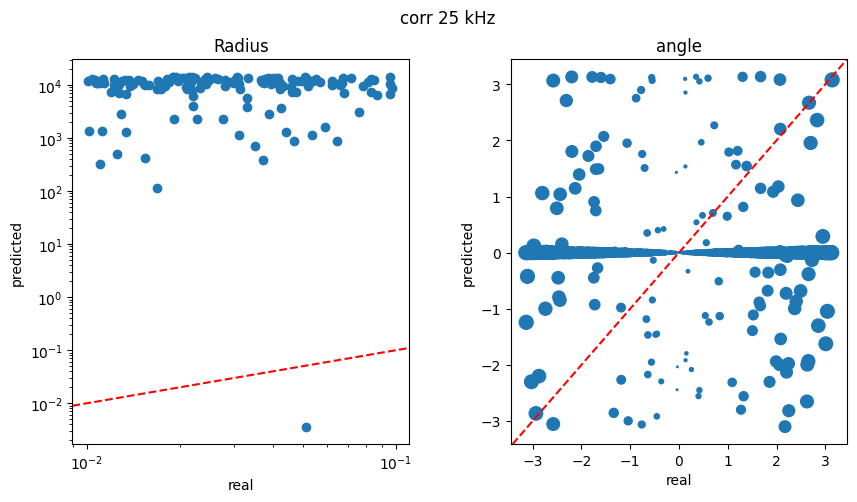

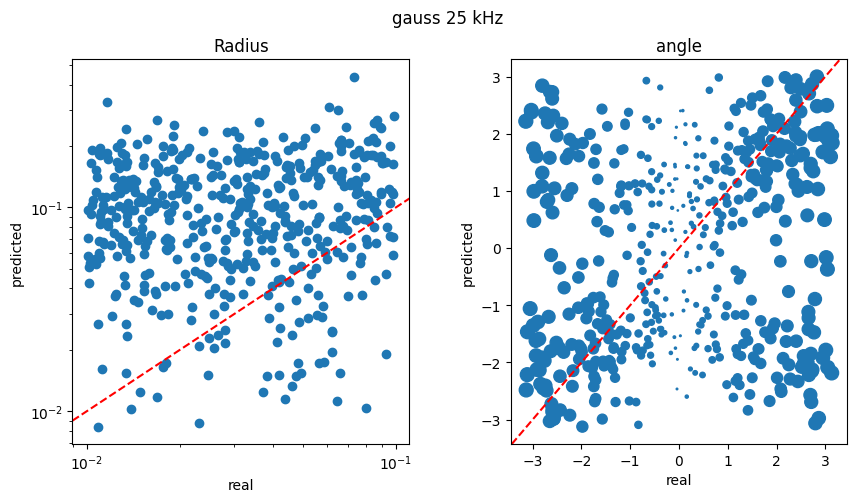

In [77]:
for result_dict, f in zip(result_dict_list, freq_list):
    for name in names_list:
        trajectory_polar_comparison(result_dict[name], name+ f" {f} kHz")


#'for result in results_list:
#    name = result["name"]
#    trajectory_polar_comparison(results, name)

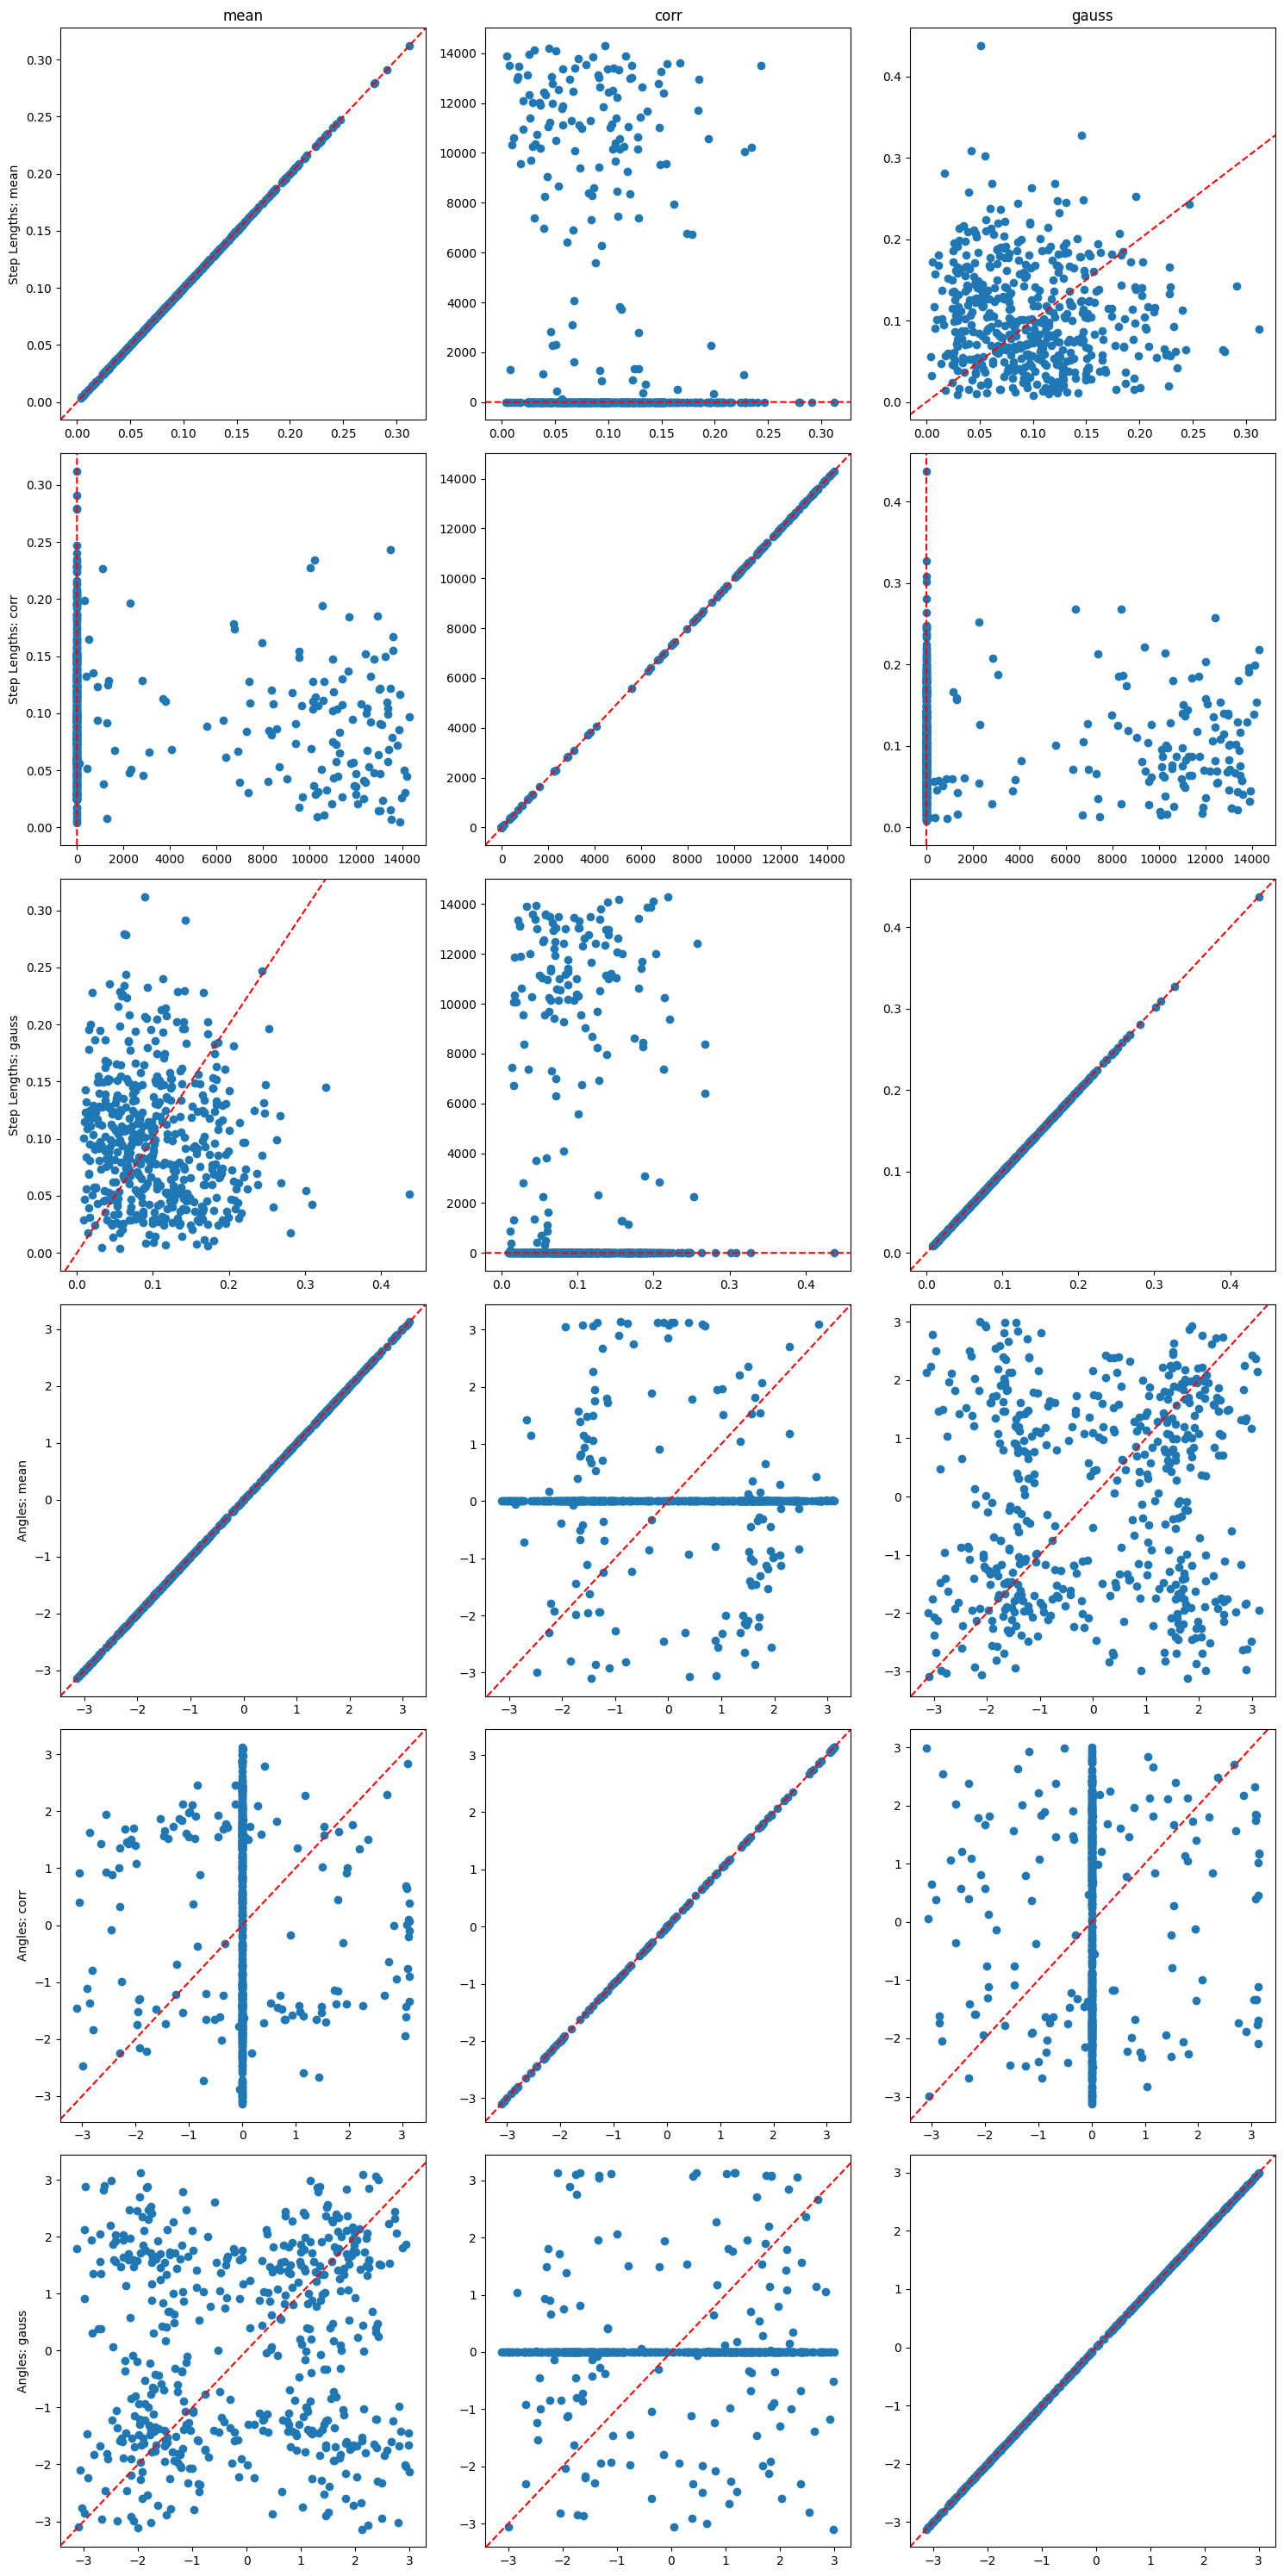

In [80]:
compare_multiple_trajectories(trajectories, names_list)

In [79]:
def xy_to_rp(x, y):
    # Convert Cartesian to polar coordinates
    r = np.sqrt(x**2 + y**2)
    p = np.arctan2(y, x)
    return r, p

def compare_multiple_trajectories(trajectories, names, size_scale=100):
    n = len(trajectories)
    fig, axs = plt.subplots(2*n, n, figsize=(15, 30))

    for i, trajectorie_i in enumerate(trajectories):
        for j, trajectorie_j in enumerate(trajectories):
            steps_i, steps_j = [], []
            
            for k in range(len(trajectorie_i) - 1):
                steps_i.append(trajectorie_i[k+1] - trajectorie_i[k])
                steps_j.append(trajectorie_j[k+1] - trajectorie_j[k])
                
            steps_polar_i = np.array([xy_to_rp(s[0], s[1]) for s in steps_i])
            steps_polar_j = np.array([xy_to_rp(s[0], s[1]) for s in steps_j])

            # Plot step lengths
            axs[i, j].scatter(steps_polar_i[:, 0], steps_polar_j[:, 0])
            axs[i, j].axline((0, 0), slope=1, color='red', linestyle='--')
            
            # Plot angles
            axs[i+n, j].scatter(steps_polar_i[:, 1], steps_polar_j[:, 1])
            axs[i+n, j].axline((0, 0), slope=1, color='red', linestyle='--')
            
            # Only set titles for the top row and labels for the leftmost plots
            if i == 0:
                axs[i, j].set_title(names[j])
            if j == 0:
                axs[i, 0].set_ylabel(f"Step Lengths: {names[i]}")
                axs[i+n, 0].set_ylabel(f"Angles: {names[i]}")

    plt.tight_layout()
    plt.show()
